# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Import" data-toc-modified-id="Import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import</a></div><div class="lev1 toc-item"><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></div><div class="lev1 toc-item"><a href="#Training-data" data-toc-modified-id="Training-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training data</a></div><div class="lev1 toc-item"><a href="#Plot-results" data-toc-modified-id="Plot-results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plot results</a></div><div class="lev1 toc-item"><a href="#Cross-validated-curve" data-toc-modified-id="Cross-validated-curve-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Cross-validated curve</a></div>

# Import

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.optimize import least_squares
import json

In [1]:
from matplotlib import rcParams
import matplotlib.lines as mlines
rcParams['figure.figsize'] = (10, 6)
rcParams['legend.fontsize'] = 16
rcParams['axes.labelsize'] = 16

# Load data

In [4]:
with open('../data/ProxDenois_7_Sat_Apr__1_15-17-55_2017.json', 'r+', encoding='utf-8') as fp:
    pd_data = json.load(fp)

pd_sqZ = np.array(pd_data['sqNormZ'])
logNvec = 1 + np.arange(7)

# Training data

In [5]:
logN_train = np.c_[logNvec].repeat(100, axis=1).ravel()
logMSE_train = np.log(pd_sqZ).ravel()

In [6]:
def candidateFunc(w, t):
    return (t ** w[0]) * (w[1] + w[2] * np.log(w[3]*t + w[4]))

def candidateFuncPrint(w):
    return 't^{:5.3} * ({:5.3} + {:5.3}*log({:5.3}t + {:5.3}))'.format(*w)

In [7]:
def candidateLoss(w, logN, logMSE):
    return candidateFunc(w, logN) - logMSE

In [8]:
w0 = np.ones(5)

In [9]:
res_robust = least_squares(candidateLoss, w0, loss='soft_l1', f_scale=.1, args=(logN_train, logMSE_train))

In [10]:
candidateFuncPrint(res_robust.x)

't^-0.421 * ( 0.67 +  12.3*log(0.113t +  0.93))'

In [14]:
res_robust

0.0060141435834495383

# Plot results

In [11]:
logN_test = np.linspace(.5, 8, 100)
logMSE_pred = candidateFunc(res_robust.x, logN_test)

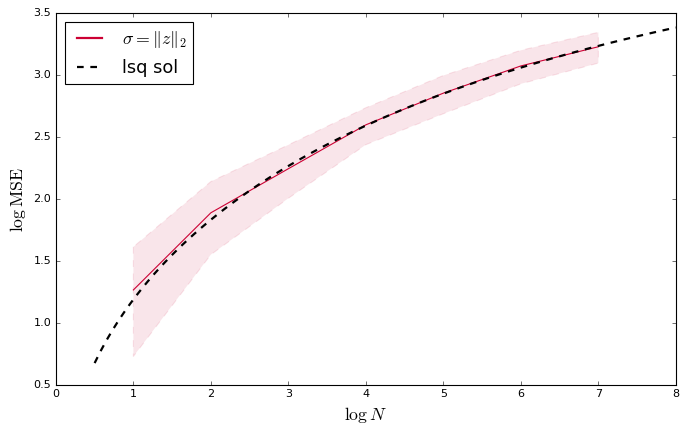

In [13]:
# Plot MSE as a function of log(N)
plt.figure()

# mean and std
pdsqZ_mean = pd_sqZ.mean(axis=1)
pdsqZ_std = pd_sqZ.std(axis=1)

# Plot the fills
plt.fill_between(logNvec.ravel(), np.log(pdsqZ_mean-pdsqZ_std), np.log(pdsqZ_mean+pdsqZ_std), 
                 alpha=.1, linestyle='dashed', color=(.8,0,.2))

# Plot the means
plt.plot(logNvec.ravel(), np.log(pdsqZ_mean), c=(.8,0,.2,1));

# See if we can get an analytic approximation to the lines
plt.plot(logN_test, logMSE_pred, 'k--', linewidth=2)

# Make the legend
red_line = mlines.Line2D([],[], c=(.8, 0, .2), lw=2, 
                         label='$\\sigma = \\|z\\|_2$')
black_predline = mlines.Line2D([],[], c=(0,0,0), 
                               lw=2, linestyle='--', 
                               label='lsq sol')
plt.legend(handles=[red_line, black_predline], loc=2, ncol=1)

# Add the title and labels
#plt.title('Plot of $\\mathbb{E} \\|\\hat x(\\sigma) - x\\|_2^2$' + \
#          ' for $x\\in \\mathbb{R}^{10^n}$ and $\\sigma^2 = \\|z\\|_2^2$',
#          fontsize=fontSize)
plt.xlabel('$\\log\\,N$')
plt.ylabel('$\\log\\,\\mathrm{MSE}$');

# Cross-validated curve

Truly, it would be better if we obtained our result via cross-validation, but also I think the noisy distribution is large enough that perhaps we can be satisfied with the result we're getting for now. 

Another option would be to compare a model *with* a $\log$ term and one without. But at what point does this cease to be a good use of time? 